# Skin Disease Detection in Dogs to Prevent Infections and Enable Timely Intervention.

- Aryan Dutt
- Prince
- Maria Camila Villamizar 

In [2]:
#pip install kagglehub

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashmotiani/dogs-skin-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\camii\.cache\kagglehub\datasets\yashmotiani\dogs-skin-disease-dataset\versions\1


In [4]:
import os
import shutil

def move_dataset_to_notebook_directory(source_subfolder, target_folder_name="Dogs"):
    """
    Copies the dataset folder dynamically to the directory where the notebook is located.

    Args:
        source_subfolder (str): Subfolder name in the original dataset structure.
        target_folder_name (str): Name of the folder to create in the notebook directory for the dataset.

    Returns:
        str: Path to the copied dataset folder in the notebook directory.
    """
    # Get the current notebook directory
    notebook_dir = os.getcwd()

    # Locate the source dataset folder dynamically from the kagglehub cache structure
    kagglehub_path = os.path.expanduser("~/.cache/kagglehub/datasets/yashmotiani/dogs-skin-disease-dataset/versions/1")
    source_path = os.path.join(kagglehub_path, source_subfolder)

    # Check if source folder exists
    if not os.path.exists(source_path):
        raise FileNotFoundError(f"The source folder '{source_subfolder}' does not exist at {source_path}.")

    # Target path in the notebook directory
    target_path = os.path.join(notebook_dir, target_folder_name)

    # Check if the target folder already exists
    if os.path.exists(target_path):
        print(f"The folder '{target_folder_name}' already exists in {notebook_dir}.")
        return target_path

    # Copy the dataset to the notebook directory
    shutil.copytree(source_path, target_path)
    print(f"Dataset successfully copied to {target_path}.")
    
    return target_path

# Example usage:
# Name of the subfolder containing the dataset (e.g., "Dogs")
source_subfolder = "Dogs"

# Move the dataset to the notebook directory
new_data_path = move_dataset_to_notebook_directory(source_subfolder)

# Verify contents of the new dataset folder
print("Contents of the new dataset folder:", os.listdir(new_data_path))

Dataset successfully copied to C:\Users\camii\Documents\U\Term 1\Term 1\Machine Learning\Project\MLProject\Dogs.
Contents of the new dataset folder: ['Bacterial_dermatosis', 'Fungal_infections', 'Healthy', 'Hypersensitivity_allergic_dermatosis']


## Preprocessing 

In [6]:
# Dynamically set the path to the 'Dogs' folder in the same directory as the notebook
current_dir = os.getcwd()  # Get the current working directory
data_path = os.path.join(current_dir, "Dogs")

# Verify the directory exists and show its contents
if not os.path.exists(data_path):
    raise FileNotFoundError(f"The dataset folder 'Dogs' does not exist in {current_dir}. Please add the dataset.")
print("Contents of the dataset directory:")
print(os.listdir(data_path))

Contents of the dataset directory:
['Bacterial_dermatosis', 'Fungal_infections', 'Healthy', 'Hypersensitivity_allergic_dermatosis']


In [7]:
#pip install opencv-python

In [8]:
#pip install opencv-contrib-python

In [9]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [10]:
def preprocess_images(data_path, img_size=(128, 128)):
    """
    Load images, resize them, normalize, and split into train and test sets.

    Args:
        data_path (str): Path to the dataset directory.
        img_size (tuple): Target size for image resizing.

    Returns:
        tuple: Training and testing datasets (images and labels).
    """
    images = []
    labels = []
    class_names = os.listdir(data_path)
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_path, class_name)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    # Read image
                    img = cv2.imread(file_path)
                    if img is not None:  # Ensure the file is a valid image
                        # Resize image to uniform dimensions
                        img = cv2.resize(img, img_size)
                        # Convert image to RGB (if needed)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        # Append to lists
                        images.append(img)
                        labels.append(label)
    
    # Check if images list is empty
    if not images:
        raise ValueError("No valid images found in the dataset directory. Please check your dataset.")

    # Convert to numpy arrays for further processing
    images = np.array(images)
    labels = np.array(labels)

    # Normalize pixel values to range [0, 1]
    images = images / 255.0

    # Split dataset into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, class_names

In [11]:
X_train, X_test, y_train, y_test, class_names = preprocess_images(data_path)

# Print dataset information
print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")
print(f"Classes: {class_names}")

Training set size: 351, Testing set size: 88
Classes: ['Bacterial_dermatosis', 'Fungal_infections', 'Healthy', 'Hypersensitivity_allergic_dermatosis']


### Augmentating data

In [13]:
#pip install tensorflow

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(X_train, y_train, batch_size=32):
    """
    Augment the training data to prevent overfitting.

    Args:
        X_train (np.array): Training images.
        y_train (np.array): Training labels.
        batch_size (int): Number of samples per batch.

    Returns:
        generator: Augmented data generator.
    """
    # Define augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,          # Rotate images by up to 20 degrees
        width_shift_range=0.1,      # Shift width by 10%
        height_shift_range=0.1,     # Shift height by 10%
        shear_range=0.1,            # Shear transformation
        zoom_range=0.2,             # Zoom in and out
        horizontal_flip=True,       # Flip images horizontally
        fill_mode="nearest"         # Fill missing pixels
    )

    # Fit the generator to the training data
    generator = datagen.flow(X_train, y_train, batch_size=batch_size)

    return generator

# Example usage
batch_size = 32
train_generator = augment_data(X_train, y_train, batch_size)


## Training the model 

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

def create_cnn(input_shape, num_classes):
    """
    Create a Convolutional Neural Network (CNN) model.

    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).
        num_classes (int): Number of output classes.

    Returns:
        model: A compiled CNN model.
    """
    model = Sequential()

    # Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the output
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to reduce overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [37]:
# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=len(class_names))
y_test_encoded = to_categorical(y_test, num_classes=len(class_names))

# Create the CNN model
input_shape = X_train.shape[1:]  # (128, 128, 3)
model = create_cnn(input_shape, num_classes=len(class_names))

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded), batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_accuracy:.2f}")

C:\Users\camii\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.2847 - loss: 1.5947 - val_accuracy: 0.2955 - val_loss: 1.4044
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3620 - loss: 1.3523 - val_accuracy: 0.2273 - val_loss: 1.3898
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.3344 - loss: 1.3278 - val_accuracy: 0.2841 - val_loss: 1.3708
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.3190 - loss: 1.2859 - val_accuracy: 0.3182 - val_loss: 1.3598
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4136 - loss: 1.2432 - val_accuracy: 0.3068 - val_loss: 1.3400
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.4464 - loss: 1.1821 - val_accuracy: 0.3295 - val_loss: 1.2974
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5036 - loss: 1.1136 - val_accuracy: 0.3977 - val_loss: 1.2331
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5338 - loss: 1.0965 - val_accuracy: 0.3864 -

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


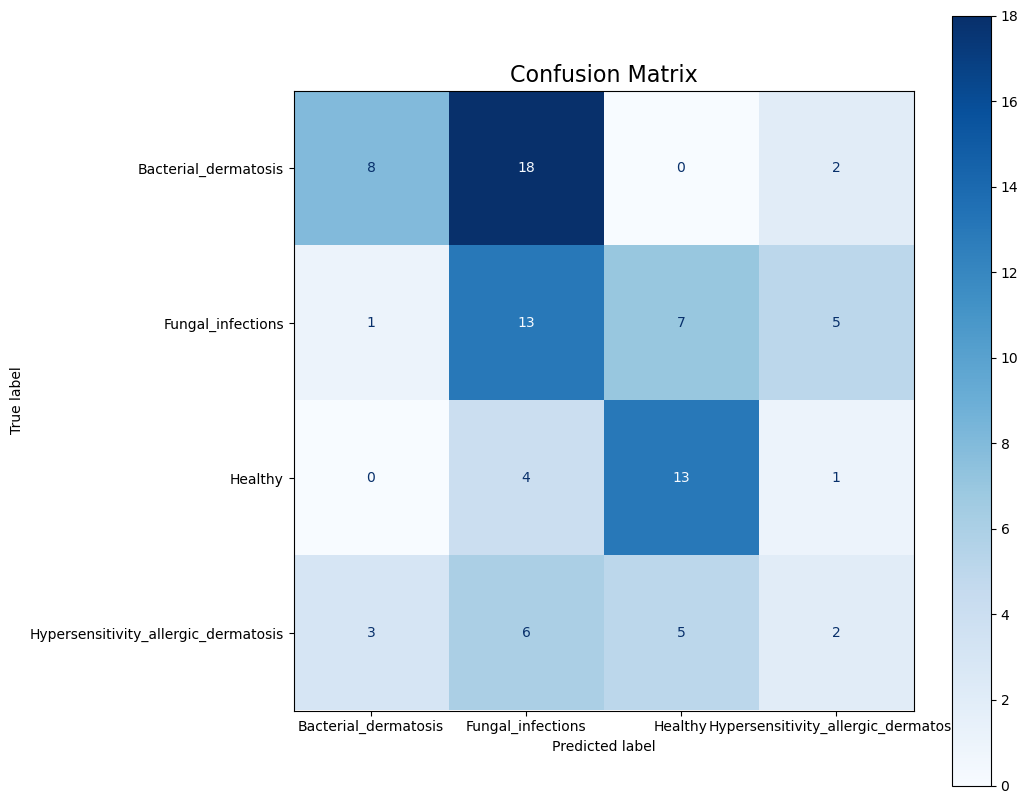

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get the predicted classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_true = np.argmax(y_test_encoded, axis=1)  # Convert one-hot encoded labels to class indices

# Step 2: Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Step 3: Display the confusion matrix with larger size
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size (width, height)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass the ax to the plot function
plt.title("Confusion Matrix", fontsize=16)  # Set a larger title font size
plt.show()


In [41]:
from collections import Counter
print(Counter(y_train))  # Check the distribution of samples in each class


Counter({1: 111, 2: 101, 3: 73, 0: 66})


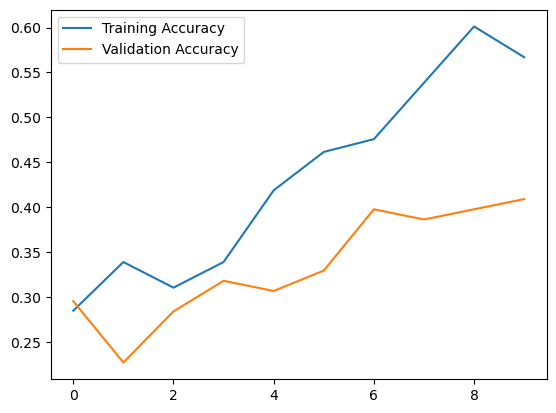

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
